# Analyse des données textuelles

À partir des données l'application [Yelp](https://www.yelp.fr), traiter les sujets d'insatisfaction dans les commentaires client.

**Analyser les commentaires pour détecter les différents sujets d’insatisfaction**
 - pré-traitement des données textuelles
 - utilisation de techniques de réduction de dimension
 - visualisation des données de grandes dimensions

**Collecter un échantillon (environ 200 restaurants) de données via l’API Yelp**
 - récupérer uniquement les champs nécessaires
 - stocker les résultats dans un fichier exploitable (par exemple csv)
 
 
Cette deuxième partie concerne le modèle **Non Negative Matrix Factorization (NMF)** afin de trouver le nombre et le genre des sujets d'insatisfaction.


## Non Negative Matrix Factorization

La NMF décompose les caractéristiques des données originales (matrice) en un produit de deux matrices de rang inférieur. La NMF utilise une approche itérative pour modifier les valeurs initiales des 2 nouvelle matrices afin que le produit se rapproche le plus des données originales. Lorsque l'erreur d'approximation converge ou que le nombre d'itérations défini par l'utilisateur est atteint, la NMF se termine.

# Chargement des bibliothèques

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import random


In [2]:
# Nécessaire lors de la phase de développement pour mettre à jour la classe olist dans le notebook
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
data_dir = '../data/'

# Entrainement du modèle

## Chargement des données précédement traitées

In [5]:
df = pd.read_csv(data_dir + 'train_reviews.csv')
test = pd.read_csv(data_dir + 'test_reviews.csv')

## Création du corpus

In [6]:
# tf_idf = TfidfVectorizer()
# La même vectorisation est conservée pour tous les modèles 
tf_idf = pickle.load(open("models/TfidfVectorizer.pkl", "rb"))
tf_idf_data = tf_idf.fit_transform(df['clean_text'])

## Recherche du nombre de topics
Pour la recherche du nombre optimale de topics, nous allons utiliser le coefficient de silhoutte.

Le **coefficient de Silhouette** vérifie si chaque document a bien été classé. Un document est bien classé si la distance qui le sépare de la classe la plus proche est très supérieure à celle qui le sépare de sa classe.

In [7]:
nmf_scores = []

In [8]:
for n_components in range(2, 20, 3):
    nmf = NMF(n_components=n_components, random_state=63,alpha=.1, l1_ratio=.5, max_iter=3000)
    nmf.fit(tf_idf_data)
    nmf_features = nmf.transform(tf_idf_data)
    labels = nmf_features.argmax(axis=1)
    score = silhouette_score(tf_idf_data, labels)
    nmf_scores.append(score)
    print(f"Cluster {n_components}: Silhouette score {score:.4f}")

Cluster 2: Silhouette score 0.0045
Cluster 5: Silhouette score 0.0041
Cluster 8: Silhouette score 0.0042
Cluster 11: Silhouette score 0.0049
Cluster 14: Silhouette score 0.0056
Cluster 17: Silhouette score 0.0058


# Sélection du nombre de topics

Text(0.5, 1.0, 'Estimation du nombre de clusters avec le coefficient de silhouette')

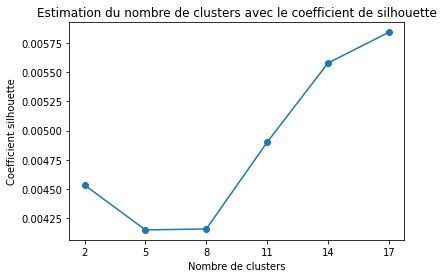

In [9]:
f, ax = plt.subplots(1, 1)
ax.plot(range(2, 20, 3), nmf_scores, marker='o')
ax.set_xlabel('Nombre de clusters')
ax.set_xticks(range(2, 20, 3))
ax.set_xticklabels(range(2, 20, 3))
ax.set_ylabel('Coefficient silhouette')
ax.set_title('Estimation du nombre de clusters avec le coefficient de silhouette')

D'après le modèle NMF le nombre de topic optimal est 8.

Nous allons tenter d'expliquer les topics trouvés avec les mots clés qui ont été classés.

# Explication des topics

In [10]:
num_topics = 8

In [11]:
nmf = NMF(n_components=num_topics, random_state=63,alpha=.1, l1_ratio=.5, max_iter=3000)
nmf.fit(tf_idf_data)
nmf_features = nmf.transform(tf_idf_data)
pickle.dump(nmf, open("models/nmf.pkl", "wb"))

In [12]:
new_df = pd.read_csv(data_dir + 'london_clean.csv')
new_df = new_df[new_df['bad_review'] == 1]
rand_obs = random.sample(list(new_df.index), 4)
for i in rand_obs:
    print(f"{i} - {new_df.loc[i]['text']}")

1763 - This is probably the first pub I've been to In London that doesn't have a vegan or vegetarian roast on their menu. They were accommodating and made a roast...
553 - Vietnamese food gone wrong! The base soup of phò beef noodle soup is not flaborful at all and in fact bland - no beef taste. There was anlot if noodles, the...
622 - I really wanted to like this spot but it fell flat in multiple ways. I don't think our server smiled once through the entire course of our meal and it was...
821 - I was ATTACKED physically in this shop. I walked in on a video phone call to show my friend what to order, and a man (pretending to be) on crutches yells:...


In [13]:
X_new = nmf.transform(tf_idf_data)
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

In [14]:
components_df = pd.DataFrame(nmf.components_, columns=tf_idf.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'Topic {topic+1}')
    print(tmp.nlargest(5))
    print('\n')


Topic 1
place    3.542317
go       2.468590
time     2.418450
like     2.047203
get      1.891055
Name: 0, dtype: float64


Topic 2
chicken    3.659420
tast       2.634059
veri       1.995331
sauc       1.963218
good       1.772597
Name: 1, dtype: float64


Topic 3
pizza    8.613572
crust    1.000144
chees    0.898529
slice    0.666048
top      0.553911
Name: 2, dtype: float64


Topic 4
order       7.927944
call        2.988517
deliveri    1.730768
time        1.459548
said        1.435058
Name: 3, dtype: float64


Topic 5
food       7.547769
servic     6.104339
good       2.407251
terribl    2.045203
horribl    1.912913
Name: 4, dtype: float64


Topic 6
wait     7.938186
minut    5.073019
hour     2.386242
min      1.375373
long     1.286084
Name: 5, dtype: float64


Topic 7
burger    7.472166
fri       2.572602
bun       0.677112
onion     0.545215
chees     0.542569
Name: 6, dtype: float64


Topic 8
us        5.133410
tabl      3.674406
ask       2.584480
drink     2.200020
server  

Les 8 topics peuvent être regroupés en 4 groupes

**Service**
 - food, servic, good, terribl, horribl

**Nourriture**
 - chicken, tast, veri, sauc, good, 
 - pizza, crust, chees, slice, top
 - burger, fri, bun, onion, chees 

**Emplacement**
 - place, go, time, like, get
 - us, tabl, ask, drink, server

**Attente**
 - wait, minut, hour, min, long
 - order, call, deliveri, time, said



# Prédictions

## Prédiction avec de données de test

In [15]:
for index, row in test.iterrows():
    words = []
    X = tf_idf.transform([row['clean_text']])
    nmf_features = nmf.transform(X)
    topic = pd.DataFrame(nmf_features).idxmax(axis=1)[0]
       
    tmp = components_df.iloc[topic]
    for w in tmp.nlargest(5).index:
        words.append(w)
    
    display(f"Topic {topic + 1} - {words}")
    display(f"{str(row['text'])}")    

"Topic 1 - ['place', 'go', 'time', 'like', 'get']"

"This place is the worst! I have contacted the district Manager multiple times about his place been closed because they don't have employees to work. People are nasty and unprofessional!! All kinds of negativeness and place had not changed!! Today was the icing on the cake!!  Person that took my order has snut coming out her nose!! The person that made my steak bowl made a mistake and used his hands to fix it.. rice is hard as bullets and it was just horrible!!  I complained to the district manager about 5 times with issues!! Store is becoming worst and worst!!  How and whom can I complaint about the store??  Horrible nasty place   Argh !!!"

"Topic 8 - ['us', 'tabl', 'ask', 'drink', 'server']"

'I was very unimpressed with the restaurant when I was there last year. I saw the good rating on yelp and figured I couldn\'t go wrong with bringing an out-of-town guest here and to a comedy club nearby. I booked a reservation several days in advance without an issue. We arrived about 10 minutes early and waited outside (fairly chilly out at that time of year) because the restaurant is VERY VERY small and there is absolutely nowhere to stand inside. When our table was ready they ushered us in and sat us at THE SMALLEST TABLE I HAVE EVER SEEN. It would have been a stretch to fit two people at a table of that size; asking three to sit there was laughable. I\'m sure the waitress saw the incredulous look on my face because a moment later she said that another table was just leaving and they would clear that off so we could sit there.   The food was fine. My pasta was pretty good, my companions were a little less thrilled with their meals. The service was fine as well but nothing of note. T

"Topic 1 - ['place', 'go', 'time', 'like', 'get']"

'The bald bar tender watched me urinate. Said that, he\'s gonna have to cut me off after "seeing my stream". I\'m sober as a joke. Not exactly the professionalism that I\'d hope for seeing how I\'ve come here for years. Smh.'

"Topic 8 - ['us', 'tabl', 'ask', 'drink', 'server']"

'I came on a whim. My server was nice enough, and it was busy so I wasn\'t expecting to be seated as quickly as I was. I asked for skim milk for my coffee, and it didn\'t come until the coffee was cold. I ordered the western omelette. It was delicious but I asked for fruit as my side and the runner told me the fruit was being cut up and would be out ASAP. Well, I finished my omelette which was quite tasty. No fruit ever came. No one ever warmed up my coffee. Then, the server brought me my bill and rushed off. I finally flagged her down after about five minutes of trying to get someone\'s attention. I told her I\'d never gotten my fruit. She goes "oh" and rushed back off. She came back with a small bowl of what looked like good fruit. She said "it was ready, but no one ever brought it. " Not "I\'m sorry" or "I apologize for your wait" or anything like it. I paid the bill, left a suitable tip and left. I won\'t be returning.'

"Topic 6 - ['wait', 'minut', 'hour', 'min', 'long']"

'I\'ve been to this location multiple times and while the food is good, the service is horrible. It doesn\'t matter if there is a line out the door or no line and am able to walk up to the register, the wait on your food is at minimum 30 minutes. So don\'t come if you\'re hungry on in a hurry. This time I visited there was no one in line, my fiancé and I waited 30 min and then went and asked how much longer it would be. Their response: we are working as fast as we can and have several to go orders we are fulfilling at the same time. 15+ min later, someone comes to our table and says or ticket was "lost" and asked if we wanted to reorder. We said no, we just wanted a refund. No incentive via gift card or otherwise to come back.'

"Topic 4 - ['order', 'call', 'deliveri', 'time', 'said']"

"Well I ordered my chicken broccoli and ziti was told 20mins went there 30mins later asked for my order 144 as I was told and the man told me there was no such order. Bad for business this is why I tend to go where I know. Try to support the local business but that's what I get."

"Topic 2 - ['chicken', 'tast', 'veri', 'sauc', 'good']"

"Tall doubles are reasonably strong but the fried shrimp is the worst I've ever had. Totally bland with no flavor of shrimp at all. Portion (5 jumbo shrimp) is not really worth the $22.  Unfortunately this is the only place that serves liquor in this terminal."

"Topic 2 - ['chicken', 'tast', 'veri', 'sauc', 'good']"

"Was very disappointed after being so hyped up by some of the reviews. Ordered to go and insured I asked for extra salsa and a side of guacamole at least 3 times. The waiter even repeated it and assured me it was included. Get home to find neither. Fajita meat was bland and didn't receive any grilled peppers that were also requested and charged for."

"Topic 6 - ['wait', 'minut', 'hour', 'min', 'long']"

'Not worth giving even 1 star. I couldn\'t tell if I was eating food. Whatever was served on the fiesta-ware plates came out very late, very cold and tasting like old mush from the bottom of a trash bin or dirty sink. Much thanks to the host staff manager who made us wait 10 minutes before taking our names with no one else in line, then handing us a  buzzer that eventually never went off so we had to go remind them (still the only people in the waiting area) that we hadn\'t been seated yet. And then finally the "food". I want my $50 back. Never again.'

"Topic 4 - ['order', 'call', 'deliveri', 'time', 'said']"

'Ordered take out that was to be 30 mins. I hour later we finally received our order. Pirate Pak burger dry, cold and unfit for consumption. Fish and chips also cold but did eat the fish which was at least fresh. Milk shake melted. I suspect that the order was ready at the 30 minute mark but somehow they either had a mix up or put the order somewhere where it was missed. Will give them the benefit of the doubt on temperature. No excuses on the Pirate Pak. If you must use this White Spot, check your  take out order before you leave the restaurant for quality and temperature. I will not return.'

## Prédiction avec de nouvelles données en provenance de l'API Yelp

## Chargement des données

In [16]:
new_df = pd.read_csv(data_dir + 'london_sample.csv')

## Prédictions

In [17]:
for index, row in new_df.iterrows():
    words = []
    X = tf_idf.transform([row['clean_text']])
    nmf_features = nmf.transform(X)
    topic = pd.DataFrame(nmf_features).idxmax(axis=1)[0]
       
    tmp = components_df.iloc[topic]
    for w in tmp.nlargest(5).index:
        words.append(w)
    
    display(f"Topic {topic + 1} - {words}")
    display(f"{str(row['text'])}")

"Topic 4 - ['order', 'call', 'deliveri', 'time', 'said']"

'Terrible service from the time I sat down. Had to flag down multiple people other than our actual waitress whom was nowhere to be found in order to order...'

"Topic 3 - ['pizza', 'crust', 'chees', 'slice', 'top']"

'If you like Burned Pizza and Bad Service that is the place for you. We ordered a pizza to go and the pizza was soggy, soft and very burned under the...'

"Topic 5 - ['food', 'servic', 'good', 'terribl', 'horribl']"

"We were frequent visitors of Vapiano's when we lived in Vienna, so we know what to expect, and I have to say their food and service were always..."

"Topic 1 - ['place', 'go', 'time', 'like', 'get']"

'Walked in for dinner. First night in London and super excited for meat & ale pie. Sat at a table upstairs. 10 minutes went by and no one came around at all....'

# Conclusion
Les deux models précédents proposaient 11 categories, alors que le NMF n'en propose que 8. On remarque que la partie commande à disparue, mais qu'elle est regroupée avec l'attente.
